In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import cv2
import glob
from skimage.transform import resize
from scipy import ndimage
from libs import utils 
import math


In [3]:
from fastai.vision import *

In [6]:
%ls dataset_2/

0.0/  1.0/  10.0/  2.0/  3.0/  4.0/  5.0/  6.0/  7.0/  8.0/  9.0/


In [9]:
data_path = "dataset_2/"

In [ ]:
# Create fast ai data 

# FAST AI MODEL

In [15]:
np.random.seed(42)

data_path = "./dataset_2/"

tfms = get_transforms(do_flip=False)

data = ImageDataBunch.from_folder(data_path, train='.', 
                                  valid_pct=0.2,
                                  ds_tfms=tfms,
                                  size=224,
                                  num_workers=4).normalize(imagenet_stats)

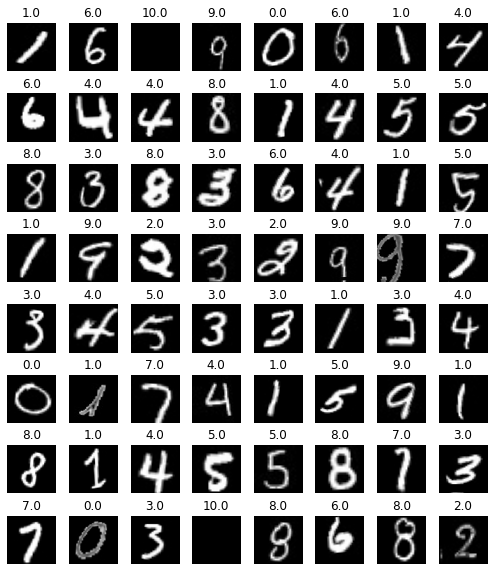

In [16]:
data.show_batch(rows=9, figsize=(7, 8))

In [17]:
data.classes

['0.0', '1.0', '10.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0']

In [18]:
data

ImageDataBunch;

Train: LabelList (66599 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1.0,1.0,1.0,1.0,1.0
Path: dataset_2;

Valid: LabelList (16649 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
7.0,0.0,8.0,0.0,6.0
Path: dataset_2;

Test: None

In [ ]:
# Learning

In [20]:
# fastai 1.0
from fastai import *
from torchvision.models import *    # import *=all the models from torchvision  

CROP_SIZE = 28
arch = resnet50                  # specify model architecture, densenet169 seems to perform well for this data but you could experiment
BATCH_SIZE = 128                    # specify batch size, hardware restrics this one. Large batch sizes may run out of GPU memory
sz = CROP_SIZE                      # input size is the crop size
MODEL_PATH = str(arch).split()[1]   # this will extrat the model name as the model file name e.g. 'resnet50'



In [10]:

# This will create an export.pkl file that you'll need to copy with your model file if you want to deploy it on another device.
# This saves the internal information (classes, etc) need for inference in a file named 'export.pkl'. 
#imgDataBunch.export(fname='./export.pkl')


In [21]:
# Next, we create a convnet learner object
# ps = dropout percentage (0-1) in the final layer
def getLearner():
    return cnn_learner(data, 
                      arch,
                      pretrained=True,
                      path='.', 
                      metrics=accuracy, 
                      ps=0.5, 
                      callback_fns=ShowGraph)

learner = getLearner()

In [27]:
%ls models/

export.pkl  resnet50_stage1.pth  tmp.pth


In [13]:
# We can use lr_find with different weight decays and record all losses so that we can plot them on the same graph
# Number of iterations is by default 100, but at this low number of itrations, there might be too much variance
# from random sampling that makes it difficult to compare WD's. I recommend using an iteration count of at least 300 for more consistent results.
lrs = []
losses = []
wds = []
iter_count = 600

# WEIGHT DECAY = 1e-6
learner.lr_find(wd=1e-6, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-6')

learner = getLearner() #reset learner - this gets more consistent starting conditions


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [17]:
# WEIGHT DECAY = 1e-4
learner.lr_find(wd=1e-4, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-4')

learner = getLearner() #reset learner - this gets more consistent starting conditions

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [18]:
# WEIGHT DECAY = 1e-2
learner.lr_find(wd=1e-2, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-2')
learner = getLearner() #reset learner

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


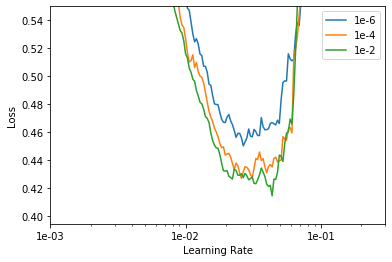

In [19]:
# Plot weight decays
_, ax = plt.subplots(1,1)
min_y = 0.5
max_y = 0.55
for i in range(len(losses)):
    ax.plot(lrs[i], losses[i])
    min_y = min(np.asarray(losses[i]).min(), min_y)
ax.set_ylabel("Loss")
ax.set_xlabel("Learning Rate")
ax.set_xscale('log')
#ax ranges may need some tuning with different model architectures 
ax.set_xlim((1e-3,3e-1))
ax.set_ylim((min_y - 0.02,max_y))
ax.legend(wds)
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))

In [29]:
#learner.model = model.cuda()
learner.model.cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

epoch,train_loss,valid_loss,accuracy,time
0,0.123361,0.165445,0.956969,05:52
1,0.126969,0.060307,0.983352,05:48
2,0.096059,0.189556,0.962119,05:47
3,0.077427,0.061193,0.986033,05:46
4,0.060467,0.051545,0.986033,05:46
5,0.034258,0.069127,0.993933,05:45
6,0.022036,0.017831,0.995203,05:45
7,0.020030,0.016437,0.995203,05:45


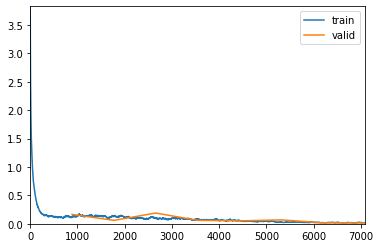

In [11]:
max_lr = 1.5e-02
wd = 1e-2
# 1cycle policy
learner.fit_one_cycle(cyc_len=8, max_lr=max_lr, wd=wd)

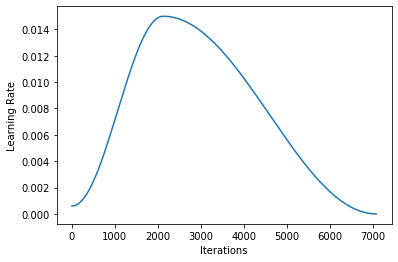

In [12]:
# plot learning rate of the one cycle
learner.recorder.plot_lr()

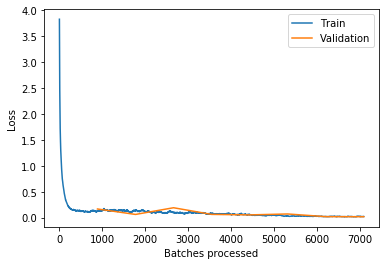

In [13]:
# and plot the losses of the first cycle
learner.recorder.plot_losses()

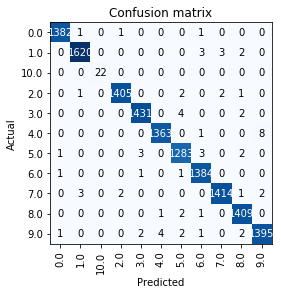

In [14]:
# predict the validation set with our model
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')

In [15]:
print(MODEL_PATH)

resnet50


In [17]:
preds,y, loss = learner.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))


The accuracy is 0.9952031373977661 %.


## Finetunning

In [30]:
max_lr = 1.5e-02
wd = 1e-2

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


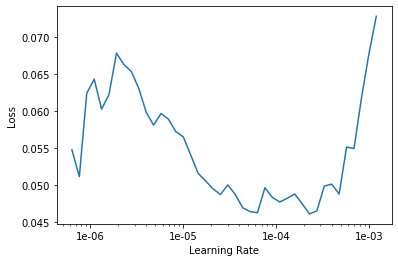

In [32]:
# Finetunning

# load the baseline model
learner.load(MODEL_PATH + '_stage1')

# unfreeze and run learning rate finder again
learner.unfreeze()

learner.lr_find(wd=wd)

# plot learning rate finder results
learner.recorder.plot()

In [33]:
learner.model.cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

epoch,train_loss,valid_loss,accuracy,time
0,0.033197,0.017520,0.995495,09:19
1,0.045679,0.023193,0.994054,09:21
2,0.043520,0.469186,0.991051,09:21
3,0.039110,0.029664,0.991831,09:21
4,0.031189,0.047671,0.993633,09:21
5,0.032506,0.023467,0.993093,09:21
6,0.014522,0.020920,0.994414,09:21
7,0.027305,0.020547,0.994714,09:22
8,0.017326,0.018004,0.995555,09:21
9,0.010346,0.017580,0.995495,09:21


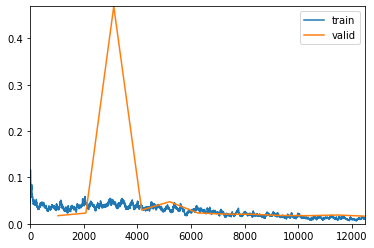

In [34]:
# Now, smaller learning rates. This time we define the min and max lr of the cycle
learner.fit_one_cycle(cyc_len=12, max_lr=slice(2e-5,2e-4))

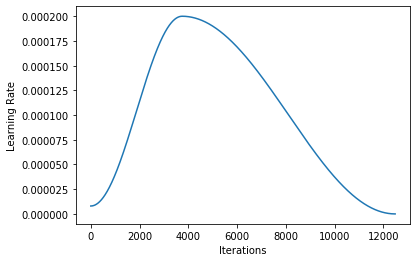

In [35]:
# plot learning rate of the one cycle
learner.recorder.plot_lr()

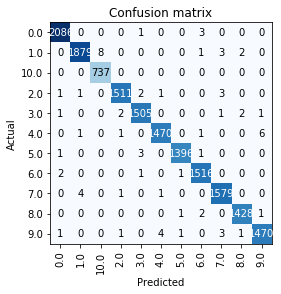

In [36]:
# predict the validation set with our model
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')

In [37]:
preds,y, loss = learner.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))


The accuracy is 0.9956754446029663 %.


In [38]:
# before we continue, lets save the model at this stage
learner.save(MODEL_PATH + '_stage2')

In [ ]:
# Validation



In [26]:
# I modified this from the fastai's plot_top_losses (https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L114)
from random import randint

def plot_overview(interp:ClassificationInterpretation, classes=['Negative','Tumor']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    fig.suptitle('Predicted / Actual / Loss / Probability',fontsize=20)
    # Random
    for i in range(4):
        random_index = randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        im = image2np(im.data)
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.data)
        ax[1,i].imshow(im)
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.data)
        ax[2,i].imshow(im)
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

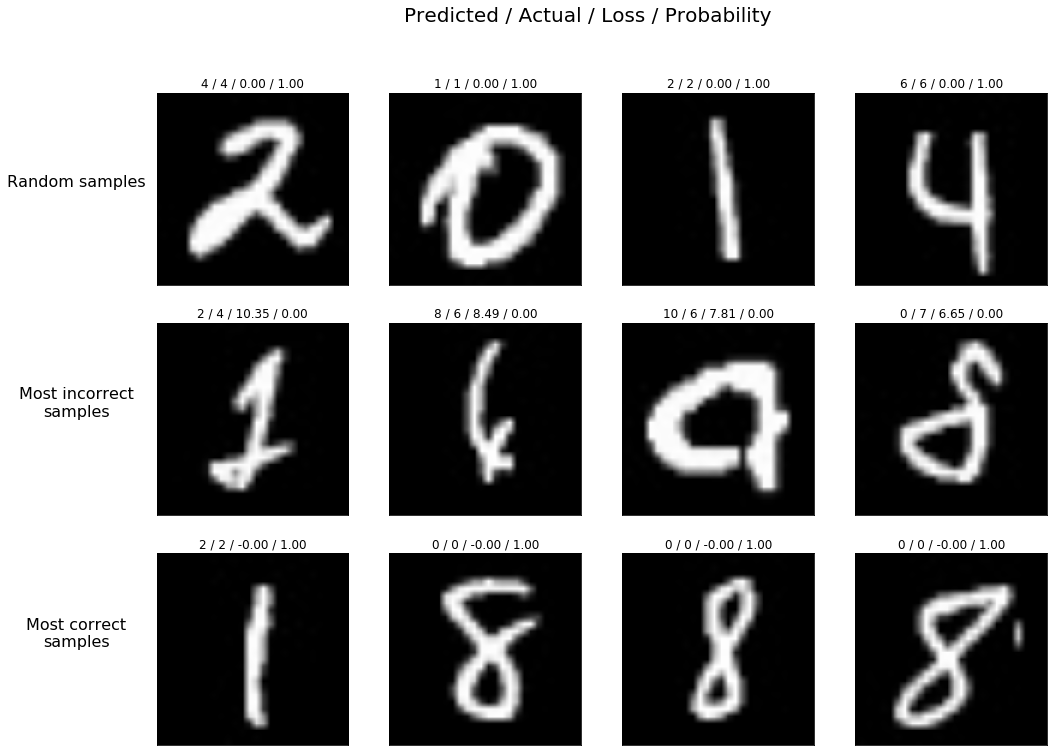

In [27]:
#interp = ClassificationInterpretation.from_learner(learner)
plot_overview(interp, labels)

In [35]:
from fastai.callbacks.hooks import *
from fastai.vision import *


# hook into forward pass
def hooked_backward(m, oneBatch, cat):
    # we hook into the convolutional part = m[0] of the model
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(oneBatch)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [43]:
# We can create a utility function for getting a validation image with an activation map
def getHeatmap(val_index):
    """Returns the validation set image and the activation map"""
    # this gets the model
    m = learner.model.eval()
    tensorImg,cl = data.valid_ds[val_index]
    # create a batch from the one image
    oneBatch,_ = data.one_item(tensorImg)
    oneBatch_im = vision.Image(data.denorm(oneBatch)[0])
    # convert batch tensor image to grayscale image with opencv
    cvIm = cv2.cvtColor(image2np(oneBatch_im.data), cv2.COLOR_RGB2GRAY)
    # attach hooks
    hook_a,hook_g = hooked_backward(m, oneBatch, cl)
    # get convolutional activations and average from channels
    acts = hook_a.stored[0].cpu()
    #avg_acts = acts.mean(0)

    # Grad-CAM
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1).mean(1)
    grad.shape,grad_chan.shape
    mult = (acts*grad_chan[...,None,None]).mean(0)
    return mult, cvIm

In [37]:
# Then, modify our plotting func a bit
def plot_heatmap_overview(interp:ClassificationInterpretation, classes=['Negative','Tumor']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    fig.suptitle('Grad-CAM\nPredicted / Actual / Loss / Probability',fontsize=20)
    # Random
    for i in range(4):
        random_index = randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].imshow(im, cmap=plt.cm.gray)
        ax[0,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[1,i].imshow(im)
        ax[1,i].imshow(im, cmap=plt.cm.gray)
        ax[1,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[2,i].imshow(im)
        ax[2,i].imshow(im, cmap=plt.cm.gray)
        ax[2,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

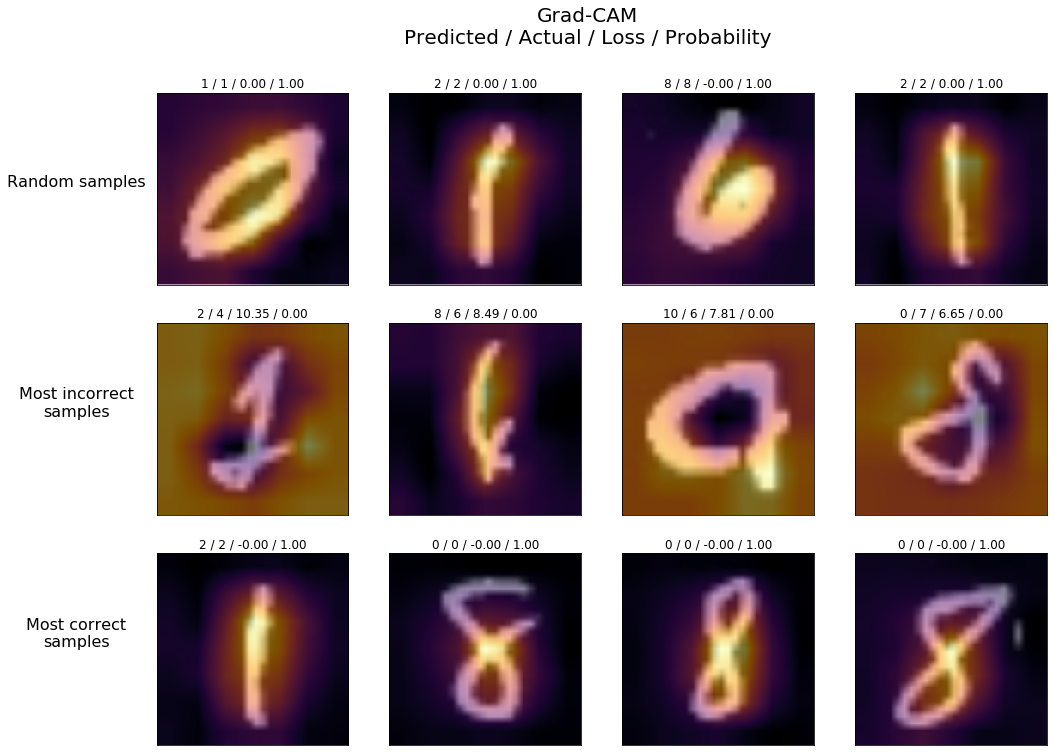

In [63]:
plot_heatmap_overview(interp, labels)

In [ ]:
# ROC Curves

In [45]:
from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

ROC area is 0.9999854612342658


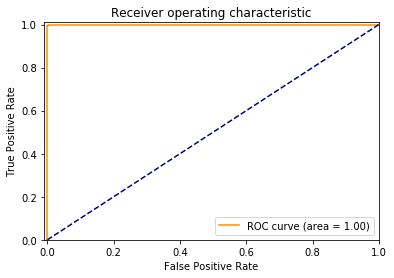

In [46]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")


In [52]:
# Export
# This will create an export.pkl file that you'll need to copy with your model file if you want to deploy it on another device.
# This saves the internal information (classes, etc) need for inference in a file named 'export.pkl'. 
data.export('./export.pkl')


In [60]:
%mv "dataset/export.pkl" "models/"

In [62]:
%ls models

export.pkl  resnet50_stage1.pth  tmp.pth


In [ ]:
######## RUN THIS ON A NEW MACHINE ##########
from fastai.vision import * # fastai 1.0
from fastai import *
from torchvision.models import *
arch = densenet169       # specify model architecture
MODEL_PATH = str(arch).split()[1] + '_stage2'
empty_data = ImageDataBunch.load_empty('./') #this will look for a file named export.pkl in the specified path
    learner = create_cnn(empty_data, arch).load(MODEL_PATH)